In [27]:
import pandas as pd
import numpy as np

In [28]:
# Load the dataset
df = pd.read_csv("train.csv")

# Preview the first few rows
df.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [29]:
# Extract surname from Name before dropping
df['Last_Name'] = df['Name'].str.split(',').str[0]

# Drop Name and Ticket
df.drop(['Name', 'Ticket'], axis=1, inplace=True)

In [30]:
# Fill missing Age values with median age by Pclass
df['Age'] = df.groupby('Pclass')['Age'].transform(
    lambda x: x.fillna(x.median())
)

In [31]:
# Fill missing cabin for family members by using family's known cabin
family_cabins = df.groupby('Last_Name')['Cabin'].agg(
    lambda x: x.dropna().iloc[0] if x.notna().any() else np.nan
)

# Fill missing cabins with family cabin if available
df['Cabin'] = df.apply(
    lambda row: family_cabins[row['Last_Name']]
    if pd.isna(row['Cabin'])
    else row['Cabin'],
    axis=1
)

# Replace any still-missing cabins with "Unknown"
df['Cabin'] = df['Cabin'].fillna("Unknown")

In [32]:
# Format Fare to 2 decimal places
df['Fare'] = df['Fare'].round(2)

In [33]:
# Remove any duplicate rows
df.drop_duplicates(inplace=True)

In [34]:
# Convert data types
df['Survived'] = df['Survived'].astype(int)
df['Pclass'] = df['Pclass'].astype(int)
df['Sex'] = df['Sex'].astype('category')
df['Embarked'] = df['Embarked'].astype('category')
df['Cabin'] = df['Cabin'].astype(str)

In [35]:
# Drop temporary Last_Name column
df.drop('Last_Name', axis=1, inplace=True)

In [36]:
# Save the cleaned dataset
df.to_csv("titanic_cleaned_final.csv", index=False)
print("✅ Cleaned dataset saved as 'titanic_cleaned_final.csv'.")

✅ Cleaned dataset saved as 'titanic_cleaned_final.csv'.


In [37]:
df = pd.read_csv("titanic_cleaned_final.csv")

df.head(10)

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,1,0,3,male,22.0,1,0,7.25,Unknown,S
1,2,1,1,female,38.0,1,0,71.28,C85,C
2,3,1,3,female,26.0,0,0,7.92,Unknown,S
3,4,1,1,female,35.0,1,0,53.10,C123,S
4,5,0,3,male,35.0,0,0,8.05,B5,S
5,6,0,3,male,24.0,0,0,8.46,Unknown,Q
6,7,0,1,male,54.0,0,0,51.86,E46,S
7,8,0,3,male,2.0,3,1,21.08,Unknown,S
8,9,1,3,female,27.0,0,2,11.13,Unknown,S
9,10,1,2,female,14.0,1,0,30.07,Unknown,C


## Training the Random Forest Model

We use a Random Forest Classifier, which is an ensemble of decision trees.  
It is robust, handles both numerical and categorical data, and helps reduce overfitting.

- `model.fit(X_train, y_train)` trains the model on the training data.

In [38]:
from sklearn.model_selection import train_test_split

features = ["Pclass", "Sex", "SibSp", "Parch"]
X = pd.get_dummies(df[features])
y = df["Survived"]

# Split data for validation (80% train, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

## 2. Training the Random Forest Model

We use a Random Forest Classifier, which is an ensemble of decision trees.  
It is robust, handles both numerical and categorical data, and helps reduce overfitting.

In [39]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=1)
model.fit(X_train, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,5
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


## 3. Evaluating Model Performance

After training, we predict the outcomes for the validation set and evaluate the results:

- **Validation Accuracy:** The proportion of correct predictions on the validation set.
- **Confusion Matrix:** Shows the counts of true positives, true negatives, false positives, and false negatives.
- **Classification Report:** Includes precision, recall, and F1-score for each class (survived/did not survive).

In [40]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

y_pred = model.predict(X_val)
print("Validation Accuracy:", accuracy_score(y_val, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred))
print("Classification Report:\n", classification_report(y_val, y_pred))

Validation Accuracy: 0.7988826815642458
Confusion Matrix:
 [[91 14]
 [22 52]]
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.87      0.83       105
           1       0.79      0.70      0.74        74

    accuracy                           0.80       179
   macro avg       0.80      0.78      0.79       179
weighted avg       0.80      0.80      0.80       179



## 4. Feature Importance

Random Forests can tell us which features were most important for making predictions.

- The bar plot shows the relative importance of each feature.
- Features with higher bars contributed more to the model's decisions.

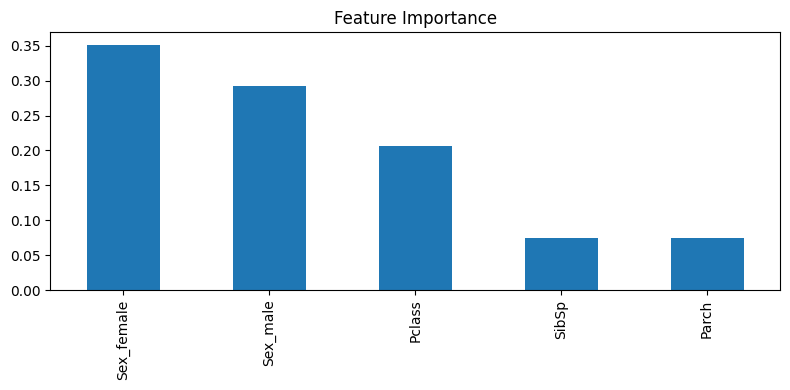

In [41]:
import matplotlib.pyplot as plt
import pandas as pd

feat_imp = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(8,4))
feat_imp.plot(kind='bar')
plt.title('Feature Importance')
plt.tight_layout()
plt.show()